## The effects of adversarial training in voice conversion

Minimum generation error (MGE) training vs Adversarial training. Generated audio samples are available at the middle of the notebook.

Code: https://github.com/r9y9/gantts

### Refereneces

- [Yuki Saito, Shinnosuke Takamichi, Hiroshi Saruwatari, "Statistical Parametric Speech Synthesis Incorporating Generative Adversarial Networks", arXiv:1709.08041 [cs.SD], Sep. 2017](https://arxiv.org/abs/1709.08041)
- [Yuki Saito, Shinnosuke Takamichi, and Hiroshi Saruwatari, "Training algorithm to deceive anti-spoofing verification for DNN-based text-to-speech synthesis," IPSJ SIG Technical Report, 2017-SLP-115, no. 1, pp. 1-6, Feb., 2017. (in Japanese)](http://sython.org/papers/SIG-SLP/saito201702slp.pdf)
- [Yuki Saito, Shinnosuke Takamichi, and Hiroshi Saruwatari, "Voice conversion using input-to-output highway networks," IEICE Transactions on Information and Systems, Vol.E100-D, No.8, pp.1925--1928, Aug. 2017](https://www.jstage.jst.go.jp/article/transinf/E100.D/8/E100.D_2017EDL8034/_article)

In [1]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

import sys
sys.path.insert(0, "..")

Populating the interactive namespace from numpy and matplotlib


In [3]:
import torch

from scipy.io import wavfile
import pysptk
from pysptk.synthesis import Synthesizer, MLSADF
import pyworld
from os.path import join, basename

from nnmnkwii import preprocessing as P
from nnmnkwii.paramgen import unit_variance_mlpg_matrix

import gantts
from hparams import vc as hp

import librosa
import librosa.display
import IPython
from IPython.display import Audio

In [4]:
data_dir = "../data/cmu_arctic_vc/"
clb_wav_dir = "/home/ryuichi/data/cmu_arctic/cmu_us_clb_arctic/wav/"
slt_wav_dir = "/home/ryuichi/data/cmu_arctic/cmu_us_slt_arctic/wav/"

data_mean = np.load(join(data_dir, "data_mean.npy"))
data_var = np.load(join(data_dir, "data_var.npy"))
data_std = np.sqrt(data_var)

In [5]:
if hp.generator_params["in_dim"] is None:
    hp.generator_params["in_dim"] = data_mean.shape[-1]
if hp.generator_params["out_dim"] is None:
    hp.generator_params["out_dim"] = data_mean.shape[-1]

In [7]:
fs = 16000
hop_length = int(fs * (hp.frame_period * 0.001))
fftlen = pyworld.get_cheaptrick_fft_size(fs)
static_dim = hp.order
checkpoints_dir = "../checkpoints/vc_test_in2out_bilstm_again/"
epoch = 200

## Models

###  Baseline: In2out highway networks

In [8]:
model_in2out = getattr(gantts.models, hp.generator)(**hp.generator_params)
print(model_in2out)

checkpoint_path = join(checkpoints_dir, "baseline/checkpoint_epoch{}_Generator.pth".format(epoch))
print("Load checkpoint from: {}".format(checkpoint_path))
checkpoint = torch.load(checkpoint_path)
model_in2out.load_state_dict(checkpoint["state_dict"])

In2OutRNNHighwayNet (
  (relu): LeakyReLU (0.01, inplace)
  (sigmoid): Sigmoid ()
  (T): Linear (59 -> 59)
  (lstm): LSTM(177, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (hidden2out): Linear (1024 -> 177)
  (dropout): Dropout (p = 0.5)
)
Load checkpoint from: ../checkpoints/vc_test_in2out_bilstm_again/baseline/checkpoint_epoch200_Generator.pth


### GAN

In [9]:
model_gan = getattr(gantts.models, hp.generator)(**hp.generator_params)
print(model_gan)

checkpoint_path = join(checkpoints_dir, "gan/checkpoint_epoch{}_Generator.pth".format(epoch))
print("Load checkpoint from: {}".format(checkpoint_path))
checkpoint = torch.load(checkpoint_path)
model_gan.load_state_dict(checkpoint["state_dict"])

In2OutRNNHighwayNet (
  (relu): LeakyReLU (0.01, inplace)
  (sigmoid): Sigmoid ()
  (T): Linear (59 -> 59)
  (lstm): LSTM(177, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (hidden2out): Linear (1024 -> 177)
  (dropout): Dropout (p = 0.5)
)
Load checkpoint from: ../checkpoints/vc_test_in2out_bilstm_again/gan/checkpoint_epoch200_Generator.pth


## Compare generated audio samples

Baseline vs GAN

In [10]:
from evaluation_vc import get_wav_files
from evaluation_vc import test_vc_from_path

src_test_files = get_wav_files(data_dir, clb_wav_dir, test=True)
tgt_test_files = get_wav_files(data_dir, slt_wav_dir, test=True)

for src_path, tgt_path in zip(src_test_files, tgt_test_files):
    fs, src_waveform = wavfile.read(src_path)
    fs, tgt_waveform = wavfile.read(tgt_path)
    
    in2out_waveform,_,_ = test_vc_from_path(model_in2out, src_path, data_mean, data_std, diffvc=True)
    gan_waveform,_,_ = test_vc_from_path(model_gan, src_path, data_mean, data_std, diffvc=True)
    
    print(basename(src_path), ": source, target, baseline, GAN")
    for x in [src_waveform, tgt_waveform, in2out_waveform, gan_waveform]:
        IPython.display.display(Audio(x, rate=fs))

arctic_a0496.wav : source, target, baseline, GAN


arctic_a0497.wav : source, target, baseline, GAN


arctic_a0498.wav : source, target, baseline, GAN


arctic_a0499.wav : source, target, baseline, GAN


arctic_a0500.wav : source, target, baseline, GAN


## Global variances

In [11]:
# Pick your favorite sample
name = "arctic_a0001.wav"

src_path = join(clb_wav_dir, name)
tgt_path = join(slt_wav_dir, name)

In [12]:
def compute_static_features(path):
    fs, x = wavfile.read(path)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=hp.frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)
    alpha = pysptk.util.mcepalpha(fs)
    mc = pysptk.sp2mc(spectrogram, order=hp.order, alpha=alpha)
    c0, mc = mc[:, 0], mc[:, 1:]
    return mc
    
def vis_gv(src_path, tgt_path):    
    tgt_mgc = compute_static_features(tgt_path)
    waveform_in2out, _, mgc_in2out = test_vc_from_path(
        model_in2out, src_path, data_mean, data_std, diffvc=True)
    waveform_gan, _, mgc_gan = test_vc_from_path(
        model_gan, src_path, data_mean, data_std, diffvc=True)
    
    figure(figsize=(16,6))
    plot(np.var(tgt_mgc, axis=0), "--", linewidth=2, label="Target: global variances")
    plot(np.var(mgc_in2out, axis=0), linewidth=2, label="In2Out: global variances")
    plot(np.var(mgc_gan, axis=0), linewidth=2, label="GAN: global variances")
    legend(prop={"size": 18})
    yscale("log")
    xlim(0, static_dim)
    xlabel("Dimention", fontsize=16)
        
    fs, src_waveform = wavfile.read(src_path)
    fs, tgt_waveform = wavfile.read(tgt_path)
    
    for x, name in [(src_waveform, "Source waveform"),
                   (tgt_waveform, "Target waveform"),
                   (waveform_in2out, "In2Out"),
                   (waveform_gan, "GAN")]:
        print(name)
        IPython.display.display(Audio(x, rate=fs))

Source waveform


Target waveform


In2Out


GAN


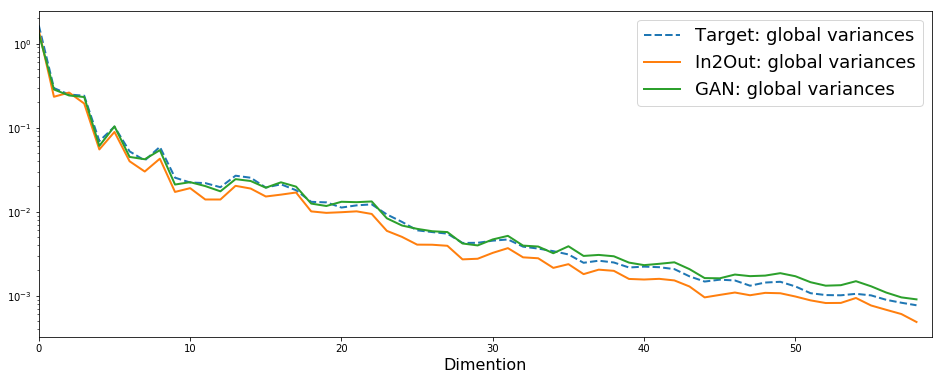

In [13]:
vis_gv(src_path, tgt_path)

## Scatter plots

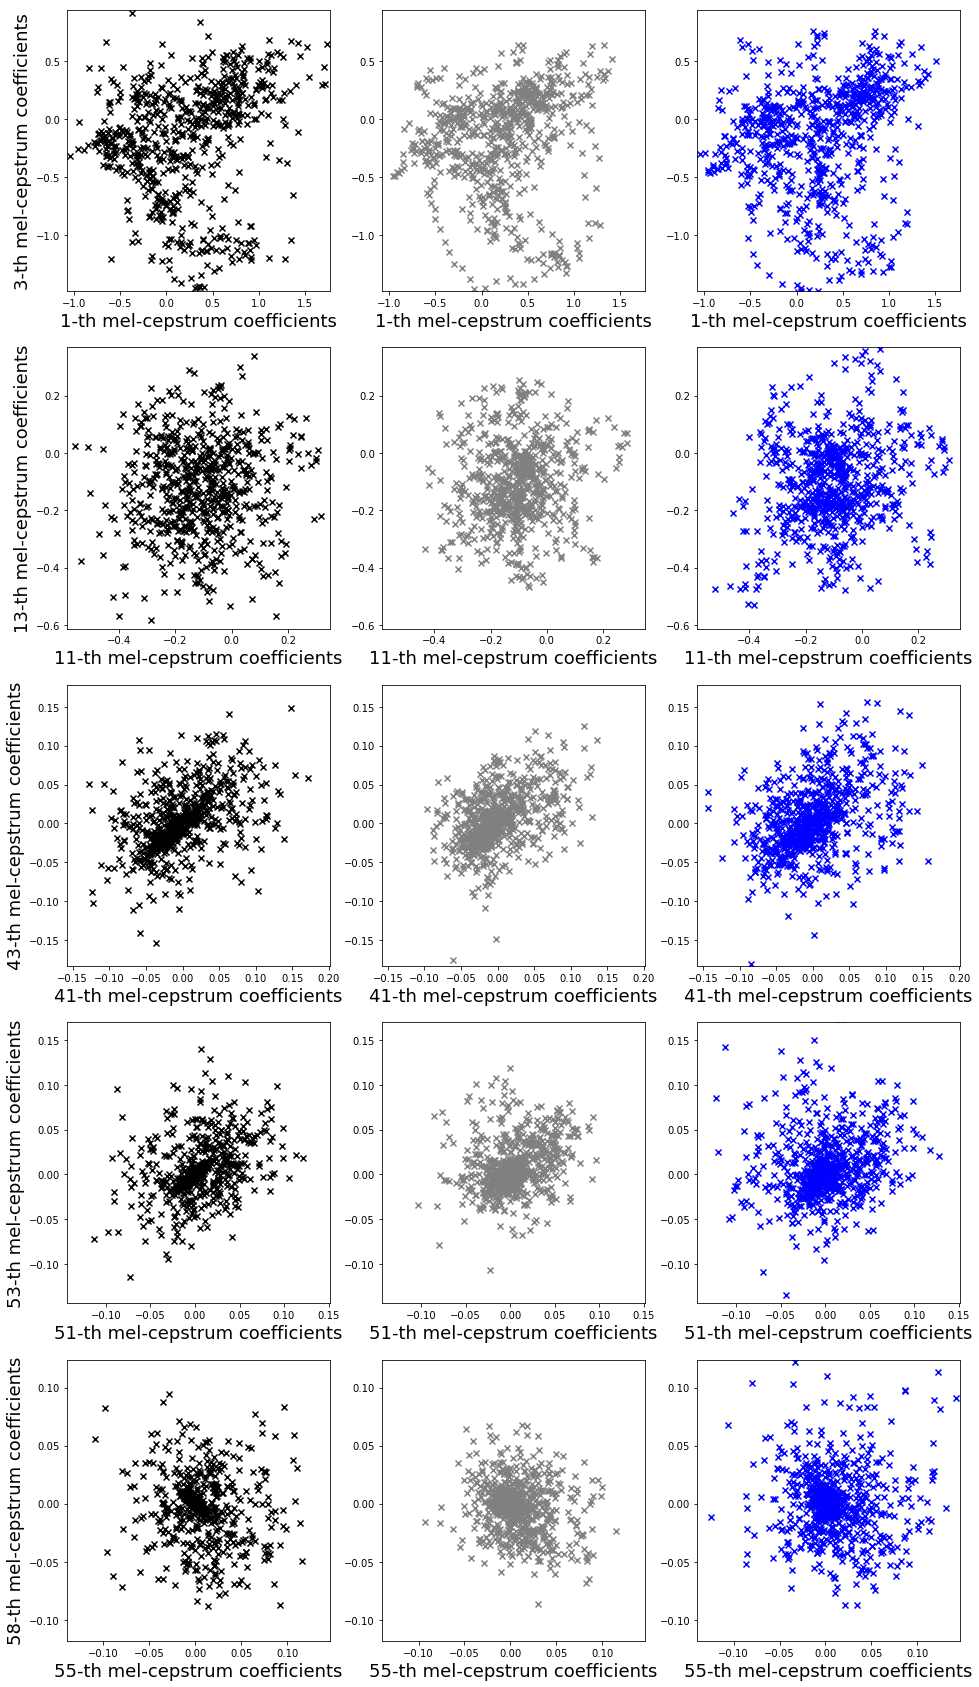

In [14]:
def scatter_plots(src_path, tgt_path):
    tgt_mgc = compute_static_features(tgt_path)
    _, _, mgc_in2out = test_vc_from_path(
        model_in2out, src_path, data_mean, data_std, diffvc=True)
    _, _, mgc_gan = test_vc_from_path(
        model_gan, src_path, data_mean, data_std, diffvc=True)

    dim_pairs = [(1, 3), (11, 13), (41, 43), (51, 53), (55, 58)]
    figure(figsize=(16,6*len(dim_pairs)))

    for pair_idx, (i, j) in enumerate(dim_pairs):
        for idx, features in enumerate([tgt_mgc, mgc_in2out, mgc_gan]):
            subplot(len(dim_pairs), 3, pair_idx*3 + 1+idx)
            c = "black" if idx == 0 else "gray" if idx == 1 else "blue"
            scatter(features[:,i], features[:,j], marker="x", c=c)            
            xlim(np.min(tgt_mgc[:,i])-0.03, np.max(tgt_mgc[:,i])+0.03)
            ylim(np.min(tgt_mgc[:,j])-0.03, np.max(tgt_mgc[:,j])+0.03)
            xlabel("{}-th mel-cepstrum coefficients".format(i), fontsize=18)
            if idx == 0:
                ylabel("{}-th mel-cepstrum coefficients".format(j), fontsize=18)
            
scatter_plots(src_path, tgt_path)

## Modulation spectrum

In [15]:
from tqdm import tnrange

ms_fftlen = 4096
modfs = fs / hop_length
ms_freq = np.arange(ms_fftlen//2 + 1)/ms_fftlen * modfs

In [16]:
src_eval_files = get_wav_files(data_dir, clb_wav_dir, test=False)
tgt_eval_files = get_wav_files(data_dir, slt_wav_dir, test=False)

In [17]:
def mean_modspec(files, model=None):
    mss = []
    for idx in tnrange(len(files)):
        f = files[idx]
        if model is not None:
            _, _, mgc = test_vc_from_path(
                model, f, data_mean, data_std, diffvc=True)
        else:       
            mgc = compute_static_features(f)
        ms = np.log(P.modspec(mgc, n=ms_fftlen))
        mss.append(ms)
    return np.mean(np.array(mss), axis=(0,))

In [18]:
ms_in2out = mean_modspec(src_eval_files, model=model_in2out)
ms_gan = mean_modspec(src_eval_files, model=model_gan)
ms = mean_modspec(tgt_eval_files)

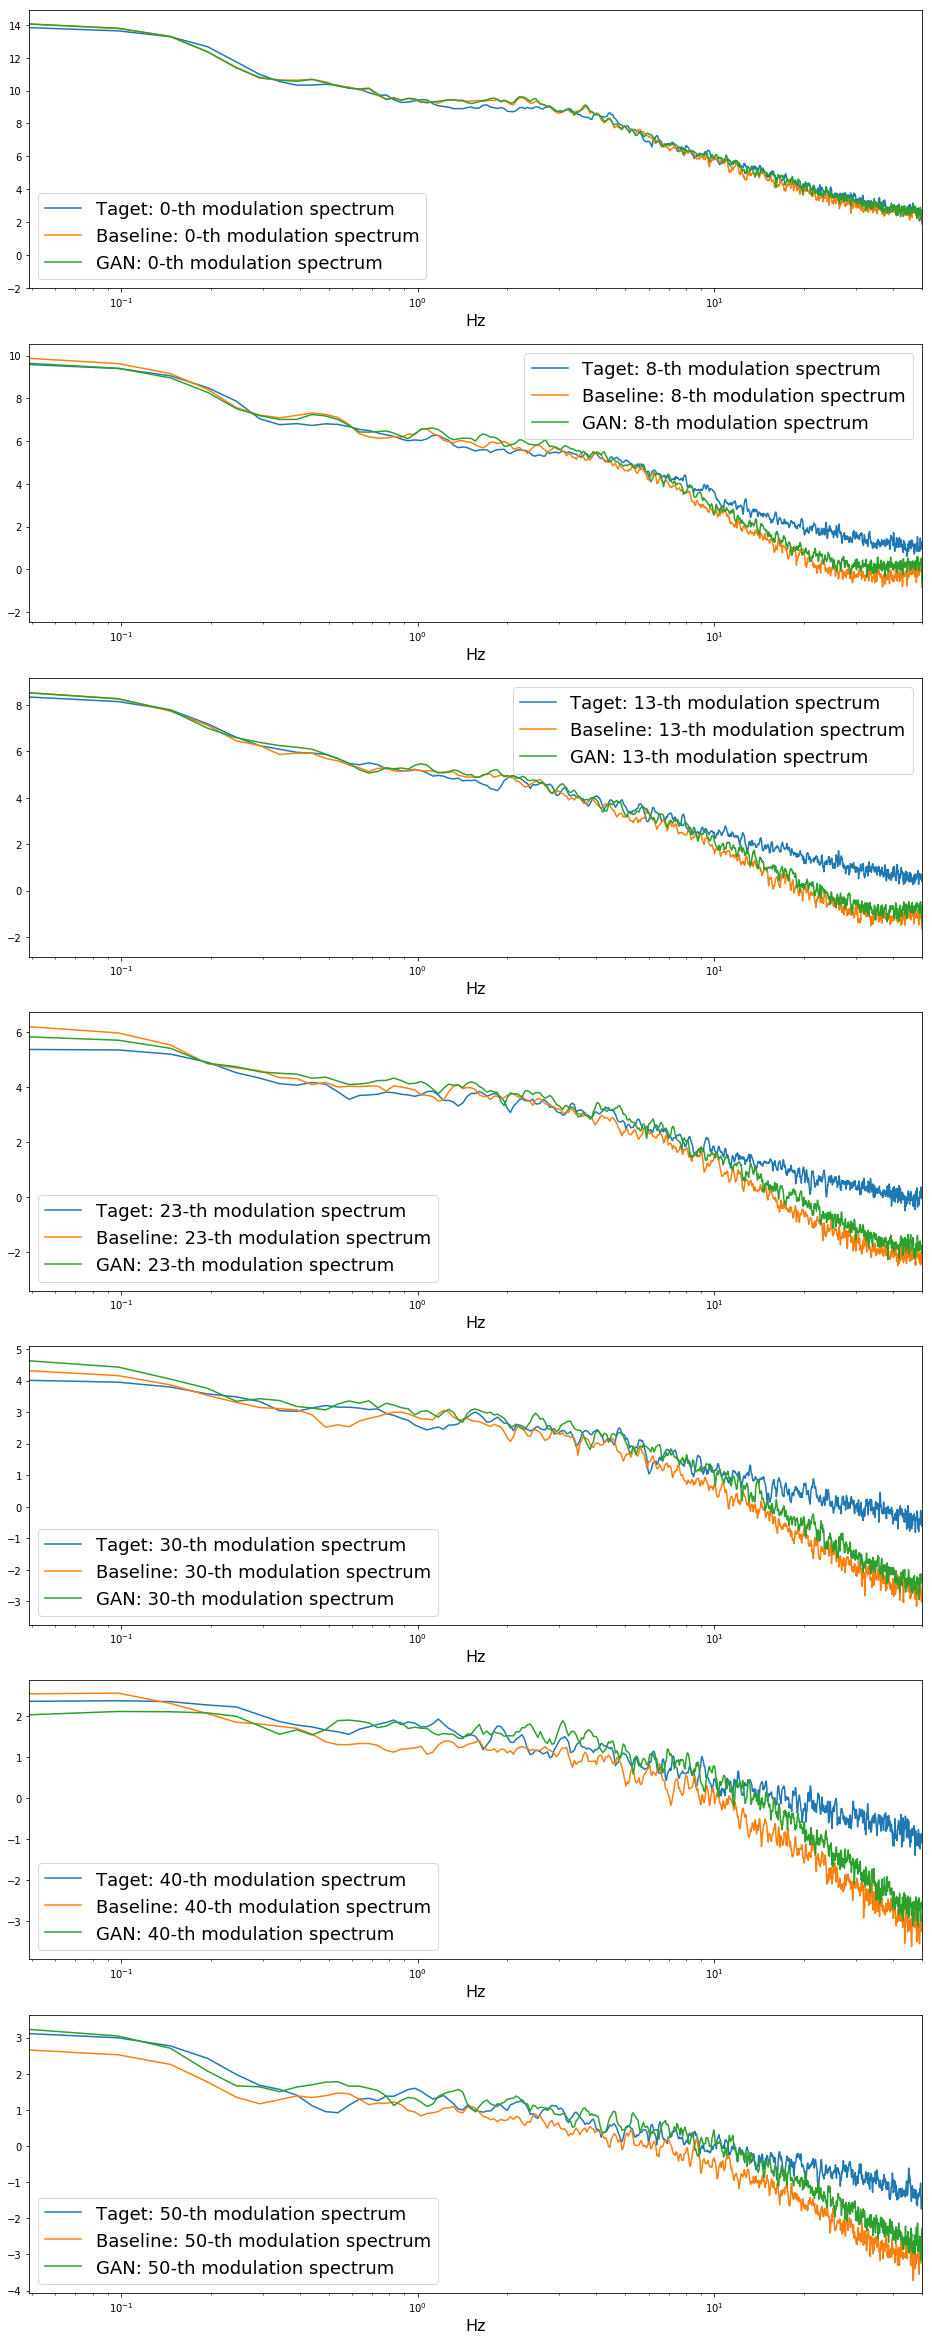

In [19]:
def vis_ms(dim=7):
    plot(ms_freq, ms[:,dim], "-", label="Taget: {}-th modulation spectrum".format(dim))
    plot(ms_freq, ms_in2out[:,dim], label="Baseline: {}-th modulation spectrum".format(dim))
    plot(ms_freq, ms_gan[:,dim], label="GAN: {}-th modulation spectrum".format(dim))
    xscale("log")
    xlabel("Hz", fontsize=16)
    xlim(0, 50) # 50hz cutoff
    # xlim(0, 100)
    legend(prop={"size": 18})

dims = [0, 8, 13, 23, 30, 40, 50]
figure(figsize=(16, 6*len(dims)))
for idx, dim in enumerate(dims):
    subplot(len(dims), 1, idx+1)
    vis_ms(dim)